### Classifying Food-101 images using ResNet-9

- Classfying food images to different types of food categories. 
- Dataset: Food-101
- Source: https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz
- Problem: Multi-class Classificaton

Import the required libraries

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Saving and uploading the python notebook to jovian 

In [ ]:
import jovian
project_name='101-food-resnet'
jovian.commit(project=project_name, evironment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

### The Dataset Food-101

The dataset 101-food has categories:
 - with total 101,000 images
 - 250 test images per class
 - 750 training images per class. 
 
All images were rescaled to have a maximum side length of 512 pixels.

Download the dataset, which is in .tgz format.

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz"
download_url(dataset_url, '.')
print("Download Complete..!!")

Using downloaded and verified file: ./food-101.tgz
Download Complete..!!


Extract the .tgz file to data folder.

In [ ]:
# Extract from archive
print("Extracting...!")
with tarfile.open('./food-101.tgz', 'r:gz') as tar:
     tar.extractall(path='./data')
print("Completed...!")

Extracting...!
Completed...!


The extracted files can be found in data directory. Check the names and number of classes.

In [ ]:
# Look into the data directory
data_dir = './data/food-101/images/'
classes = os.listdir(data_dir)
sorted(classes)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
num_classes = len(classes)
num_classes


101

The dataset contains total of 101 classes with 1000 images in each folder. The training time would be huge and might goes days and days. Therefore, only 10 classes with 1000 images each was selected as dataset and the rest were deleted. 

In [ ]:
import shutil
count = 0
choice_num_classes = 10
num_classes = num_classes - choice_num_classes  
for i in os.listdir(data_dir):
    path = data_dir + i
    if count < num_classes:
       print(path + " ... deleted!")
       shutil.rmtree(path)
       count += 1
    

./data/food-101/images/red_velvet_cake ... deleted!
./data/food-101/images/mussels ... deleted!
./data/food-101/images/sushi ... deleted!
./data/food-101/images/panna_cotta ... deleted!
./data/food-101/images/breakfast_burrito ... deleted!
./data/food-101/images/waffles ... deleted!
./data/food-101/images/eggs_benedict ... deleted!
./data/food-101/images/edamame ... deleted!
./data/food-101/images/miso_soup ... deleted!
./data/food-101/images/prime_rib ... deleted!
./data/food-101/images/oysters ... deleted!
./data/food-101/images/cheesecake ... deleted!
./data/food-101/images/crab_cakes ... deleted!
./data/food-101/images/cup_cakes ... deleted!
./data/food-101/images/ceviche ... deleted!
./data/food-101/images/chicken_quesadilla ... deleted!
./data/food-101/images/pulled_pork_sandwich ... deleted!
./data/food-101/images/garlic_bread ... deleted!
./data/food-101/images/macaroni_and_cheese ... deleted!
./data/food-101/images/fish_and_chips ... deleted!
./data/food-101/images/sashimi ...

Split the dataset to train, validation and test directory in the ratio of 80% , 10% and 10% respectively.

In [ ]:
!pip install split-folders
import splitfolders
seed_value = 42 
seed = torch.manual_seed(seed_value)
splitfolders.ratio(data_dir, output="output", seed=seed, ratio=(.8, 0.1, 0.1)) 

Copying files: 10000 files [00:07, 1296.14 files/s]


Check the classes again, as only 10 directory was selected and rest were deleted.

In [ ]:
# Look into the data directory
data_dir = './data/food-101/images/'
new_classes = os.listdir(data_dir)
sorted(new_classes)

['caesar_salad',
 'cannoli',
 'clam_chowder',
 'foie_gras',
 'lobster_bisque',
 'pad_thai',
 'pancakes',
 'ramen',
 'shrimp_and_grits',
 'tuna_tartare']

In [ ]:
num_new_classes = len(new_classes)
num_new_classes

10

The paths of splited train, validation and test directory.

In [ ]:
train_path = "./output/train/"
val_path = "./output/val/"
test_path = "./output/test/" 

Functions for counting the classes and files in each classes.

In [ ]:
#number of images in each class
def counter(path):
    classList=[]
    countList=[]
    for i in new_classes:
        count=len(os.listdir(path + i))
        classList.append(i)
        countList.append(count)
    return classList, countList 

def count(fileList):
    total_images=0
    for i in range(len(fileList)):
        total_images += fileList[i]
    return total_images        

In [ ]:
classList, countList = counter(train_path)
trainSize = count(countList)
trainSize

8000

In [ ]:
classList, countList = counter(val_path)
valSize = count(countList)
valSize

1000

In [ ]:
classList, countList = counter(test_path)
testSize = count(countList)
testSize

1000

In [ ]:
trainSize+valSize+testSize

10000

Pre-processing & Data Augumentation

In [ ]:
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))
length = 32
width = 32
train_tfms = tt.Compose([tt.Resize((length, width)), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((length, width)), tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(train_path, train_tfms)
valid_ds = ImageFolder(val_path, valid_tfms)
test_ds = ImageFolder(test_path, valid_tfms)

Create data loaders for retrieving images in batches. 

In [ ]:
batch_size = 256

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

Sample images from the training dataloader.

In [ ]:
def denormalize(images, mean, std):
    invTrans = tt.Compose([ tt.Normalize(mean=[ 0., 0., 0. ],
                            std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                            tt.Normalize(mean = [-1*mean[0], -1*mean[2], -1*mean[2] ], std = [ 1., 1., 1. ]),
                          ])
    return invTrans(images)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

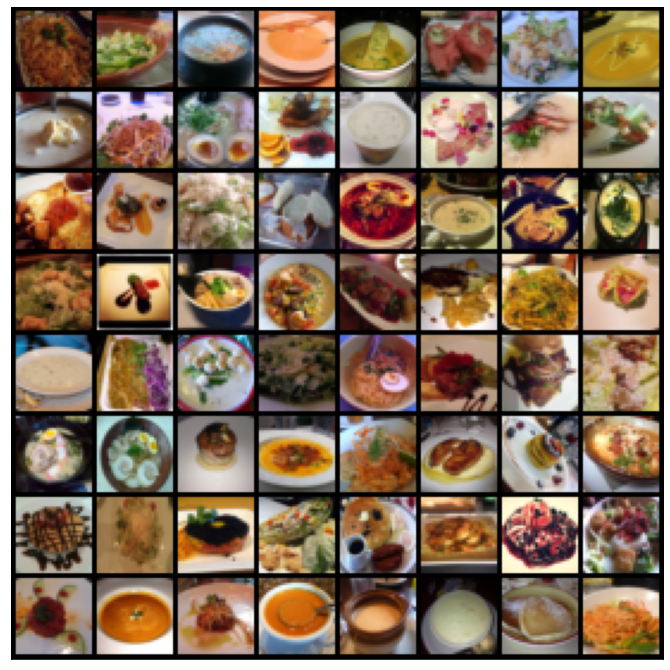

In [ ]:
show_batch(train_dl)

Using GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

Transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl =  DeviceDataLoader(test_dl, device)

## Model with Residual Blocks and Batch Normalization

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Resnet Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_new_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3,num_new_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.10245901346206665, 'val_loss': 2.304600715637207}]

### Train the model

In [ ]:
%%time
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, 
                         max_lr, 
                         model, 
                         train_dl, 
                         valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00079, train_loss: 2.1708, val_loss: 2.3151, val_acc: 0.3260
Epoch [1], last_lr: 0.00195, train_loss: 1.6903, val_loss: 1.9871, val_acc: 0.3813
Epoch [2], last_lr: 0.00368, train_loss: 1.5388, val_loss: 1.6884, val_acc: 0.4345
Epoch [3], last_lr: 0.00567, train_loss: 1.4264, val_loss: 2.2596, val_acc: 0.3734
Epoch [4], last_lr: 0.00758, train_loss: 1.5256, val_loss: 2.1110, val_acc: 0.3840
Epoch [5], last_lr: 0.00908, train_loss: 1.4740, val_loss: 2.3706, val_acc: 0.3707
Epoch [6], last_lr: 0.00989, train_loss: 1.3702, val_loss: 1.7038, val_acc: 0.4580
Epoch [7], last_lr: 0.00998, train_loss: 1.1436, val_loss: 1.6138, val_acc: 0.4937
Epoch [8], last_lr: 0.00982, train_loss: 1.0222, val_loss: 1.5600, val_acc: 0.5443
Epoch [9], last_lr: 0.00950, train_loss: 0.9277, val_loss: 1.7196, val_acc: 0.5043
Epoch [10], last_lr: 0.00905, train_loss: 0.8608, val_loss: 1.1691, val_acc: 0.6185
Epoch [11], last_lr: 0.00846, train_loss: 0.8251, val_loss: 1.7568, val_acc: 0.4846
Ep

Plotting Graphs for accuracy, loss and learning rate.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

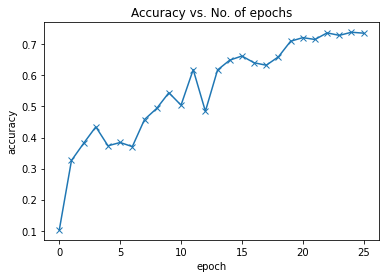

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

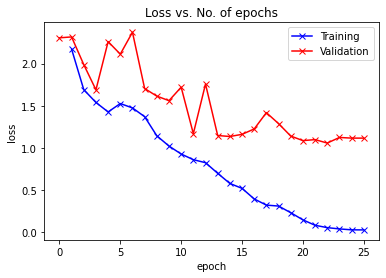

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

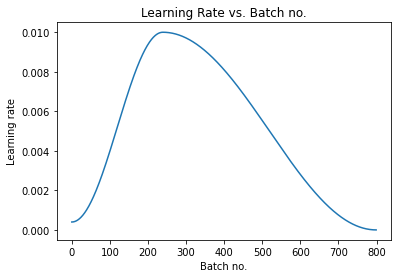

In [ ]:
plot_lrs(history)

Testing with individual images



In [ ]:
def predict_image(img, label):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)
    print(f'Label: {train_ds.classes[label]}, Predicted: {train_ds.classes[pred]}')
    img = denormalize(img, *stats)
    plt.imshow(img.permute(1, 2, 0))

Label: pad_thai, Predicted: pad_thai


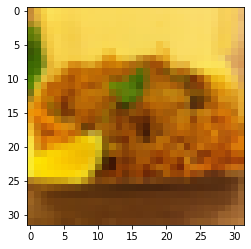

In [ ]:
import random
predict_image(*test_ds[random.randint(0, testSize)])

Label: foie_gras, Predicted: foie_gras


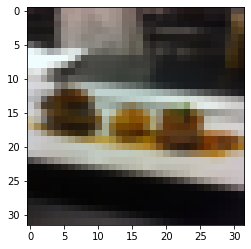

In [ ]:
predict_image(*test_ds[random.randint(0, testSize)])

Label: clam_chowder, Predicted: clam_chowder


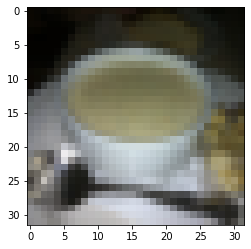

In [ ]:
predict_image(*test_ds[random.randint(0, testSize)])

Label: ramen, Predicted: ramen


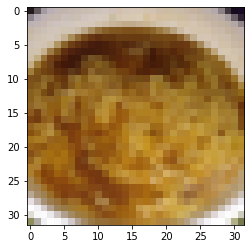

In [ ]:
predict_image(*test_ds[random.randint(0, testSize)])

Save and Commit


In [ ]:
torch.save(model.state_dict(), 'food-101-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss']
                   #, time=train_time
                   )

[jovian] Metrics logged.


In [ ]:
import jovian
jovian.commit(project=project_name, environment=None, outputs=['food-101-resnet9.pth'])

NameError: ignored